In [1]:
#Libraries
#The "TARGET" column is the variable to predict. It equals 0 for unsatisfied customers and 1 for satisfied customers.

#Models

from sklearn import decomposition
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample


#Transformation
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE

#Graphics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time
#Loading the train Data set

df_train = pd.read_csv("DataSet/train.csv")
df_test = pd.read_csv("DataSet/Test.csv")
df_Y_test = pd.read_csv("DataSet/sample_submission.csv")

Wall time: 5.94 s


In [3]:
#76020 variables and 371 observations. 
df_train.shape

(76020, 371)

In [4]:
#Check types for all collumns - Only Int and Float
dataTypeSeries = set(df_train.dtypes)
dataTypeSeries

{dtype('int64'), dtype('float64')}

In [5]:
#Removendo Colunas valores constanstes
Columns_constants=np.where(pd.Series(df_train.nunique()==1))[0]
Columns_constants
df_train.drop(df_train.columns[Columns_constants],axis=1,inplace=True)
df_train.shape

(76020, 337)

# Resempling

In [6]:
#Resample para aumentar o dataset de treino com mais classes 
X_treino_up = resample(df_train, 
                        replace=True, 
                        n_samples=df_train['TARGET'].value_counts()[0],
                        random_state=1) 
X_treino_balanced=pd.concat([df_train,X_treino_up[X_treino_up["TARGET"]==1]])


<AxesSubplot:ylabel='TARGET'>

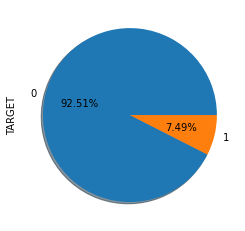

In [7]:
X_treino_balanced['TARGET'].value_counts().plot.pie(autopct='%1.2f%%',shadow=True)


In [8]:
#Dividir em X, Y de treino
Y_treino = X_treino_balanced["TARGET"]
X_treino = X_treino_balanced
X_treino.drop("TARGET", axis=1, inplace=True)
X_treino.index=X_treino["ID"]
X_treino.drop("ID", axis=1, inplace=True)
print(X_treino.shape, Y_treino.shape)

(78921, 335) (78921,)


In [9]:
#Dividir em X, Y de teste

#Mudanças para X_Test
df_test.drop(df_test.columns[Columns_constants],axis=1,inplace=True)


X_test = df_test
X_test.index = df_test["ID"]
X_test.drop("ID", axis=1, inplace=True)

#Mudanças para Y_test
Y_test=df_Y_test["TARGET"]



# Normalização dos dados

In [10]:
%%time

#Normalização dos dados de treino
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_df_treino_scaled = pd.DataFrame(X_treino_scaled, index=X_treino.index)
#Normalização dos dados de test
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_df_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index)

Wall time: 2.08 s


# Balanceamento

In [11]:
#Outro balanceamento para igualar 
scaler_x_train, scaler_x_test, scaler_y_train, scaler_y_test = train_test_split(X_df_treino_scaled, Y_treino, test_size=0.3)

<AxesSubplot:title={'center':'Count_target'}>

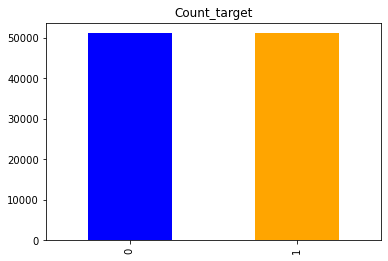

In [12]:
smote = SMOTE()
x_over, y_over = smote.fit_resample(scaler_x_train,scaler_y_train)
y_over.value_counts().plot(kind='bar',title='Count_target',color=['blue','orange'])

In [13]:
#Vericadondo o shape dos dados
print(x_over.shape,y_over.shape,X_df_test_scaled.shape,Y_test.shape)

(102188, 335) (102188,) (75818, 335) (75818,)


# Criação dos Modelos

In [14]:
%%time
## DecisionTreeClassifier
# Testando hiperparametros
clf=DecisionTreeClassifier(criterion = 'gini', 
                           max_depth=200, 
                           max_leaf_nodes=15,
                           splitter='best',
                           class_weight='balanced',
                           min_samples_leaf=760)

#Treino do modelo
clf.fit(x_over,y_over)
# check accuracy on training set
X_Pred_train = clf.predict(scaler_x_test)
#Model Accuracy
print("TRAIN Accuracy:", accuracy_score(scaler_y_test,X_Pred_train))

TRAIN Accuracy: 0.7977784347679182
Wall time: 2.87 s


Wall time: 1.41 s


<AxesSubplot:>

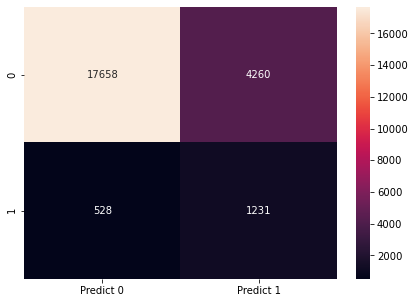

In [15]:
%%time

#confusion Matrix com o dados de treino real
from sklearn import metrics
import seaborn as sns
cm=metrics.confusion_matrix(scaler_y_test,X_Pred_train, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["0","1"]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

In [16]:
%%time
# check accuracy on training set
X_Pred_train1 = clf.predict(X_df_test_scaled)


Wall time: 142 ms


In [17]:
df_modelo_dt=pd.DataFrame(X_Pred_train1, columns=["TARGET"])
df_modelo_dt["ID"]=X_df_test_scaled.index
df_modelo_dt.to_csv(r'df_modelo_dt.csv', index = False)
print("Modelo salvo!")

Modelo salvo!


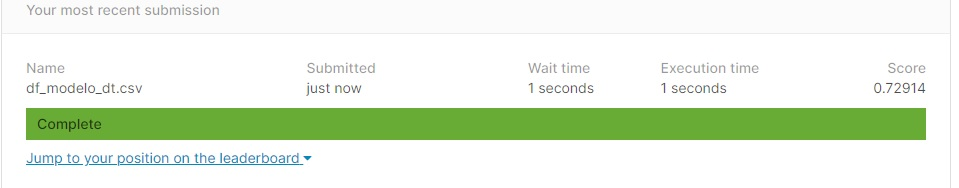

In [18]:
# Resultado no kaggle
from IPython import display
display.Image("Resultado_Kaggle.JPG")